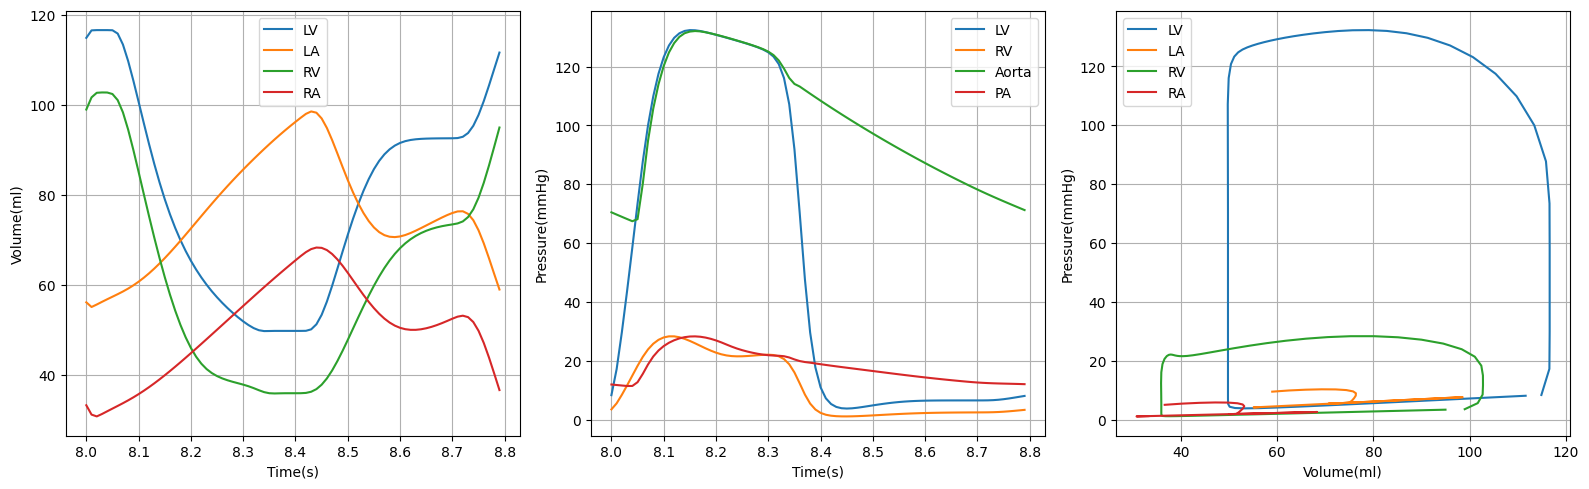

In [223]:
import numpy as np
import scipy as sp
import sympy
import math
import matplotlib.pyplot as plt
from closed_circuit import *
T=0.8
#lv = heart(tau1 = 3.14829064e-01 , tau2 =5.22438699e-01, m1 = 1.62516931e+01, m2 =4.29751520e+01 , Emax=  2 , Emin =3.73755787e-02 , V0=10, T=T)
lv=heart(tau1 = 0.269*T, tau2 = 0.452*T, m1 = 1.32, m2 = 27.4, Emax = 3, Emin = 0.08, V0 = 10,T = T, deltat = 0.01)# V0 (mL), T (s)
la=heart(tau1 = 0.110*T, tau2 = 0.180*T, m1 = 1.32, m2 = 13.1, Emax = 0.17, Emin = 0.08,V0 = 3,T = T, deltat = 0.01, delay = 0.85*T) # V0 (mL), T (s)
rv=heart(tau1 = 0.269*T, tau2 = 0.452*T, m1 = 1.32, m2 = 27.4, Emax = 0.8, Emin = 0.04, V0 = 10, T = T, deltat = 0.01) # Ks, V0 ,T
ra=heart(tau1 = 0.110*T, tau2 = 0.180*T, m1 = 1.32, m2 = 13.1, Emax = 0.15, Emin = 0.04, V0 = 3, T = T, deltat = 0.01, delay = 0.85*T) # Ks, V0, T
av=ValveinP(density = 1.06, eff_length = 2.2,Aann = 5, Kvo = 0.12,Kvc = 0.15, p_oc = 0)
mv=ValveinP(density = 1.06,eff_length =1.9,Aann = 5, Kvo = 0.3,Kvc = 0.4, p_oc = 0)
tv=ValveinP(1.06,2,6, 0.3,0.4, 0) #poc (mmHg)
pv=ValveinP(1.06,1.9,2.8, 0.2,0.2, 0) #poc
#cap_s=PressureSystem(0.001, 120, 1500)
#cap_p=PressureSystem(0.002, 20, 200)

data = np.array([
 0.00061      , 103.44867    , 1471.26289   , 0.00272      , 26.64387     , 165.27640 
])
C_s, Za_s, R_s, C_p, Za_p, R_p = data[0], data[1], data[2], data[3],data[4], data[5]
cap_s=PressureSystem(C_s, Za_s, R_s)
cap_p=PressureSystem(C_p, Za_p, R_p)
#cap_s=PressureSystem( 4.12383693e-04, 2.69001516e+02, 3.97196271e+02)
#cap_p=PressureSystem(3.06e-03, 12.5,147)#C,Za,R
#5.16297641e-03 1.94973214e+03 5.81413074e+02 8.87630760e-04 2.65996507e+02 5.30301276e+01


t_end=10
t_step = 0.01
t = [0,t_end]
t_span=np.arange(0, t_end, t_step)
aeff_av_values = []
et_lv = []
p_lv_values=[]
time=[]
def dydt(t,y):
    v_lv = y[0]
    v_la = y[1]
    q_av = y[2]
    q_mv = y[3]
    xi_av = y[4]
    xi_mv = y[5]
    #pressure of capillaries in systemic circulation
    pa = y[6]
    v_rv = y[7]
    v_ra = y[8]
    q_tv = y[9]
    q_pv = y[10]
    xi_tv = y[11]
    xi_pv = y[12]
    #pressure of capillaries in pulmonary circulation
    pb = y[13]
    
    #calculate parameters
    #systemic
    p_la = la.p(v_la,t)
    p_lv = lv.p(v_lv,t)
    #p_aa: pressure at the coupling point of av and capillaries
    p_aa = cap_s.pi(q_av,pa)
    #pulmonary
    p_ra = ra.p(v_ra,t)
    p_rv = rv.p(v_rv,t)
    #q_cap2: flow out the capillaries of pulmonary circulation
    q_cap2 = cap_p.qout(pb,p_la)
    #p_pa: pressure at the coupling point of pv and capillaries
    p_pa = cap_p.pi(q_tv,pb)
    #q_cap1: flow out the capillaries of systemic circulation
    q_cap1 = cap_s.qout(pa,p_ra)
    
    #derivative
    #la
    dv_la = la.dv(t,v_la,q_cap2,q_mv)
    dxi_mv = mv.dxi(t,xi_mv,p_la,p_lv)
    dq_mv = mv.dq(t,q_mv,xi_mv,p_la,p_lv)
    #lv
    dv_lv = lv.dv(t,v_lv,q_mv,q_av)
    dxi_av = av.dxi(t,xi_av,p_lv,p_aa)
    dq_av = av.dq(t,q_av,xi_av,p_lv,p_aa)
    #cap sys
    dpa = cap_s.dp_original(t,pa,q_av,p_ra)
    #ra
    dv_ra = ra.dv(t,v_ra,q_cap1,q_tv)
    dxi_tv = tv.dxi(t,xi_tv,p_ra,p_rv)
    dq_tv = tv.dq(t,q_tv,xi_tv,p_ra,p_rv)
    #rv
    dv_rv = rv.dv(t,v_rv,q_tv,q_pv)
    dxi_pv = pv.dxi(t,xi_pv,p_rv,p_pa)
    dq_pv = pv.dq(t,q_pv,xi_pv,p_rv,p_pa)
    #cap pul
    dpb = cap_p.dp_original(t,pb,q_pv,p_la)
    
    #derivative vector
    dy = np.array([dv_lv, dv_la, 
                   dq_av, dq_mv, 
                   dxi_av, dxi_mv, 
                   dpa, 
                   dv_rv, dv_ra, 
                   dq_tv, dq_pv, 
                   dxi_tv, dxi_pv, 
                   dpb])
    return dy
#initial condition
y_initial = np.array([135, 27, #lv, la
                      150, 10, #qav, qmv
                      0.01, 0.5, #xi_av, xi_mv
                      5*1333, #pa
                      180, 40, #v_rv, v_ra 
                      150, 10, #q_tv, q_pv
                      0.01, 0.5, #xi_tv, xi_pv
                      5*1333]) # pb

#integration
sol = sp.integrate.solve_ivp(dydt , t , y0 = y_initial , t_eval = t_span, method='LSODA')
v_lv = sol.y[0][int(1000*T):int(1100*T)]
v_la = sol.y[1][int(1000*T):int(1100*T)]
q_av = sol.y[2][int(1000*T):int(1100*T)]
q_mv = sol.y[3][int(1000*T):int(1100*T)]
xi_av = sol.y[4][int(1000*T):int(1100*T)]
xi_mv = sol.y[5][int(1000*T):int(1100*T)]
pa = sol.y[6][int(1000*T):int(1100*T)]
v_rv = sol.y[7][int(1000*T):int(1100*T)]
v_ra = sol.y[8][int(1000*T):int(1100*T)]
q_tv = sol.y[9][int(1000*T):int(1100*T)]
q_pv = sol.y[10][int(1000*T):int(1100*T)]
xi_tv = sol.y[11][int(1000*T):int(1100*T)]
xi_pv = sol.y[12][int(1000*T):int(1100*T)]
pb = sol.y[13][int(1000*T):int(1100*T)]
sol.t = sol.t[int(1000*T):int(1100*T)]
aeff_av = []
et_lv = []
B_av = []
p_lv_values = []
p_la_values = []
dp_av = []
L_av = []
dq_mv = []
dxi_mv = []
L_mv = []
B_mv = []
aeff_mv = []
dp_mv = []
dxi_av = []
et_la = []
dxi_tv = []
p_ra = []
p_rv = []
p_pa = []
dp_pv = []
p_aa = []
dxi_pv = []
dp_tv = []
q_cap2 = []
for i,j in zip(sol.t,range(len(sol.t))):
        
    aeff_av.append(av.Aeff(i, xi_av[j]))
    et_lv.append(lv.Et(i))
    et_la.append(la.Et(i))
    B_av.append(av.B(i, xi_av[j]))
    L_av.append(av.L(i, xi_av[j]))
    p_lv_values.append(lv.p(v_lv[j], i))
    p_la_values.append(la.p(v_la[j], i))
    p_aa.append(cap_s.pi(q_av[j],pa[j]))
    q_cap2.append(cap_p.qout(pb[j],p_la_values[j]))
    dp_av.append(p_lv_values[-1]-p_aa[-1])
    
    dq_mv.append(mv.dq(i,q_mv[j],xi_mv[j],p_la_values[-1],p_lv_values[-1]))#time,q,xi,pin,pout
    dxi_mv.append(mv.dxi(i,xi_mv[j],p_la_values[-1],p_lv_values[-1]))
    L_mv.append(mv.L(i, xi_mv[j]))
    B_mv.append(mv.L(i, xi_mv[j]))
    aeff_mv.append(mv.Aeff(i, xi_mv[j]))
    dp_mv.append(p_la_values[-1]-p_lv_values[-1])
    dxi_av.append(av.dxi(i,xi_av[j],p_lv_values[j], cap_s.pi(q_av[j], pa[j])))
    
    p_ra.append(ra.p(v_ra[j],i))
    p_rv.append(rv.p(v_rv[j],i))
    dxi_tv.append(tv.dxi(i,xi_tv[j],p_ra[-1],p_rv[-1]))
    
    p_pa.append(cap_p.pi(q_pv[j],pb[j]))
    dxi_pv.append(pv.dxi(i,xi_pv[j],p_rv[-1],p_pa[-1]))
    
    dp_pv.append(p_rv[-1]-p_pa[-1])
    dp_tv.append(p_ra[-1]-p_rv[-1])

p_lv = np.array(p_lv_values)/1333
p_la = np.array(p_la_values)/1333
p_ao = np.array(p_aa)/1333
p_ra1 =np.array(p_ra)/1333
p_rv1 =np.array(p_rv)/1333
p_pul = np.array(p_pa)/1333
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(16,5))
ax1.plot(sol.t, v_lv, label='LV')
ax1.plot(sol.t, v_la, label='LA')
ax1.plot(sol.t, v_rv, label='RV')
ax1.plot(sol.t, v_ra, label='RA')
ax1.set_ylabel('Volume(ml)')
ax1.legend()
ax1.grid()
ax1.set_xlabel('Time(s)')

ax2.plot(sol.t, p_lv, label='LV')
#ax2.plot(sol.t, p_la, label='LA')
ax2.plot(sol.t, p_rv1, label = 'RV')
#ax2.plot(sol.t, p_ra1, label = 'RA')
ax2.plot(sol.t, p_ao, label='Aorta')
ax2.plot(sol.t, p_pul, label = 'PA')
ax2.set_ylabel('Pressure(mmHg)')
ax2.legend()
ax2.grid()
ax2.set_xlabel('Time(s)')

#ax3.plot(sol.t, sol.y[4], label=r'$\xi_{AV}$')
#ax3.plot(sol.t, sol.y[5], label=r'$\xi_{MV}$')
#ax3.plot(sol.t, sol.y[11], label=r'$\xi_{TV}$')
#ax3.plot(sol.t, sol.y[12], label=r'$\xi_{PV}$')
#ax3.set_ylabel(r'$\xi$')
#ax3.legend()
#ax3.grid()
#ax3.set_xlim(41.33,41.91) 
#ax3.set_xlabel('Time(s)')


ax3.plot(v_lv, p_lv, label='LV')
ax3.plot(v_la, p_la, label='LA')
ax3.plot(v_rv, p_rv1, label='RV')
ax3.plot(v_ra, p_ra1, label='RA')
ax3.set_ylabel('Pressure(mmHg)')
ax3.legend()
ax3.grid()
ax3.set_xlabel('Volume(ml)')


plt.tight_layout()
plt.savefig('two_heart_model.svg', format='svg')
plt.show()

In [203]:
max_volume_rv = max(v_rv)
min_volume_rv = min(v_rv)
svrv = max_volume_rv - min_volume_rv
rvef = sv_rv / max_volume_rv
max_volume_lv = max(v_lv)
min_volume_lv = min(v_lv)
svlv = max_volume_lv - min_volume_lv
lvef = sv_lv / max_volume_lv
maxplv = max(p_lv)
maxprv = max(p_rv1)
minaop = min(p_ao)

In [204]:
minaop

72.15464259841781

In [205]:
svrv_st = 71.7
svlv_st = 73
lvef_st = 0.54
rvef_st = 0.61
plv_max = 120
prv_max = 30
pao_min = 80
diff_svrv = ((svrv_st - svrv)/svrv_st)**2
diff_svlv = ((svlv_st - svlv)/svlv_st)**2
diff_rvef = ((rvef_st - rvef)/rvef_st)**2
diff_lvef = ((lvef_st - lvef)/lvef_st)**2
diff_pao = ((pao_min - minaop)/ pao_min)**2
diff_lvp = ((plv_max - maxplv)/plv_max)**2
diff_rvp = ((prv_max - maxprv)/prv_max)**2


In [206]:
print('lvef:', lvef, 'rvef:', rvef, 'sv_lv:', sv_lv, 'sv_rv:', sv_rv, 'plv:', maxplv, 'prv:', maxprv)

lvef: 0.5027603638832837 rvef: 0.5722998079998519 sv_lv: 61.67866785286488 sv_rv: 61.59099066198182 plv: 141.52245600697321 prv: 29.413753444652677


In [207]:
err_svrv = ((svrv_st - svrv)/svrv_st)
err_svlv = ((svlv_st - svlv)/svlv_st)
err_rvef = ((rvef_st - rvef)/rvef_st)
err_lvef = ((lvef_st - lvef)/lvef_st)
err_pao = ((pao_min - minaop)/ pao_min)
err_lvp = ((plv_max - maxplv)/plv_max)
err_rvp = ((prv_max - maxprv)/prv_max)
print('svrv:', err_svrv, 'svlv:', err_svlv, 'rvef:',err_rvef,'lvef:', err_lvef,'pao:', err_pao,'lvp:', err_lvp, 'rvp:',err_rvp)

svrv: 0.03432447149238079 svlv: 0.051187824805045086 rvef: 0.06180359344286569 lvef: 0.06896228910503023 pao: 0.09806696751977739 lvp: -0.17935380005811014 rvp: 0.01954155184491076


In [201]:
err_svrv**2 + err_svlv**2 + err_rvef**2 + err_lvef**2 + err_pao**2 +err_lvp**2 +err_rvp**2

0.04468338299478166